In [524]:
import re
import itertools
from __future__ import print_function
import pandas as pd
import datetime as dt
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.tokenize import RegexpTokenizer
import string
import scipy.sparse as sparse
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d


import spacy
import en_core_web_sm
from spacy import displacy
nlp = spacy.load('en')
#nlp = en_core_web_sm.load()
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pouria/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [525]:
# to provide serial of numbers
def gen(n):
    while True:
        yield n
        n += 1

In [526]:
df = pd.read_csv('All_Data.txt', encoding='utf-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48039 entries, 0 to 48038
Data columns (total 3 columns):
Unnamed: 0    48039 non-null int64
Ratings       30016 non-null object
Reviews       30010 non-null object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [527]:
def cleaned_reviews(x):
    return(''.join(re.sub('[^a-zA-Z_.]', ' ', x)))

In [528]:
cleaned_reviews('Cans sound fine  but the AKG branded audio cable supplied to use the headphones wired was defective. Looks like there s an intermittent in the plug on one end or the other. I used a cable I got from a     pair of headphones to test and verified it was the cable. I was actually about to return the product until I decided to check the cable. Not worth swapping the product to get a replacement  but kind of lame to get a bad    cable when you buy a      pair of cans   UPDATE        The left earcup now only produces static when used with Bluetooth  just sent the phones back for repair. They were used exclusively wirelessly at my desk at work. The  AKG  branded plastic cover on the USB charge cable also came loose  making AKG   for   on cables. As an additional comment  the plastic logo panels on the sides of the headphones are a glossy finish that shows every single fingerprint. Overall  the quality is very poor for headphones in this price range  and I would not recommend them at this price. Might be worth it at            unless of course they die after   months like mine.Update       After   weeks  still waiting on a replacement for the return I made. AKG s outsourced Indian customer support informed me that they are closing my service request  so apparently I paid     for UPS Ground in order to have Harmon Kardon throw away my headphones for me. I would at this point suggest that another manufacturer not under the HK umbrella might be a better use of your money.Final Update       HK Customer Service apparently just closed my case after a month without actually sending a warranty replacement and just stopped responding to my inquiries  Summary  HK doesn t honor their warranty. Worst customer service experience I ve had in    years  no joke.')

'Cans sound fine  but the AKG branded audio cable supplied to use the headphones wired was defective. Looks like there s an intermittent in the plug on one end or the other. I used a cable I got from a     pair of headphones to test and verified it was the cable. I was actually about to return the product until I decided to check the cable. Not worth swapping the product to get a replacement  but kind of lame to get a bad    cable when you buy a      pair of cans   UPDATE        The left earcup now only produces static when used with Bluetooth  just sent the phones back for repair. They were used exclusively wirelessly at my desk at work. The  AKG  branded plastic cover on the USB charge cable also came loose  making AKG   for   on cables. As an additional comment  the plastic logo panels on the sides of the headphones are a glossy finish that shows every single fingerprint. Overall  the quality is very poor for headphones in this price range  and I would not recommend them at this pri

In [529]:

def get_bigram_likelihood(statements, freq_filter=3, nbest=200):
    """
    Returns n (likelihood ratio) bi-grams from a group of documents
    :param        statements: list of strings
    :param output_file: output path for saved file
    :param freq_filter: filter for # of appearances in bi-gram
    :param       nbest: likelihood ratio for bi-grams
    """

    #words = list()
    #tokenize sentence into words
    #for statement in statements:
        # remove non-words
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(statements)

    bigram_measures = nltk.collocations.BigramAssocMeasures()
    bigram_finder = BigramCollocationFinder.from_words(words)

    # only bi-grams that appear n+ times
    bigram_finder.apply_freq_filter(freq_filter)

    # TODO: use custom stop words
    bigram_finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in nltk.corpus.stopwords.words('english'))

    bigram_results = bigram_finder.nbest(bigram_measures.likelihood_ratio, nbest)

    return bigram_finder.score_ngrams(bigram_measures.likelihood_ratio)

In [530]:
df['Reviews'] = df['Reviews'].apply(lambda x : cleaned_reviews(str(x)))

In [531]:
review_list = df['Reviews'].tolist()
print(len(review_list))
raw_text = ''.join(review_list)

48039


In [532]:
bigrams = get_bigram_likelihood(raw_text.lower(), freq_filter=100, nbest=200 )
bigram_joint = [' '.join(list(s[0])) for s in bigrams]

In [533]:
bigram_joint

['sound quality',
 'battery life',
 'year old',
 'customer service',
 'noise cancelling',
 'stopped working',
 'ear buds',
 'great sound',
 'highly recommend',
 'good sound',
 'noise canceling',
 'outside noise',
 'blue tooth',
 'would recommend',
 'noise cancellation',
 'build quality',
 'long time',
 'work great',
 'much better',
 'pretty good',
 'head phones',
 'daughter loves',
 'price point',
 'great product',
 'high end',
 'one side',
 'another pair',
 'works great',
 'phone calls',
 'volume control',
 'son loves',
 'second pair',
 'light weight',
 'foam tips',
 'noise isolation',
 'really good',
 'ear pieces',
 'bluetooth headphones',
 'battery lasts',
 'works well',
 'good quality',
 'sound isolation',
 'low end',
 'high quality',
 'definitely recommend',
 'ear piece',
 'highly recommended',
 'make sure',
 'ear canal',
 'crystal clear',
 'long periods',
 'well made',
 'christmas gift',
 'background noise',
 'really like',
 'carrying case',
 'sound great',
 'every day',
 'ear mo

In [534]:
def check_collocation_type(doc, collocation):
    index = []
    length =len(doc)
    for i in range(length-1):
        if collocation.split(' ')[0] in [doc[i].text, doc[i].lemma_]:
            if collocation.split(' ')[1] in [doc[i+1].text, doc[i+1].lemma_]:
                index.append(i)
    if len(index)> 0:
        return [(doc[index[0]].text, doc[index[0]+1].text),(doc[index[0]].pos_, doc[index[0]+1].pos_)]
    else:
        return False

def select_sentence(review, collocation):
    sentence_list = review.split('.')
    selected_sentences = [sentence for sentence in sentence_list if collocation in sentence]
    
    return ' '.join(selected_sentences)
    
def gen(n):
    while True:
        yield n
        n += 1
        

In [535]:
selected_collocations_with_type = []
for collocation in bigram_joint:

    selected_data = [select_sentence(review.lower(), collocation) for review in review_list if collocation in review]

    
    g = gen(0)
    while True:
        index = next(g)
        if index >= len(selected_data):
            break
        review = selected_data[index]
        doc= nlp(review)
        check = check_collocation_type(doc, collocation)
        if check != False:
            if  'DET' in check[1]:
                break
            if  'NUM' in check[1]:
                break
            if check[1][1] == 'ADJ':
                break
            if check[1][0] == 'ADJ' and check[1][1] == 'ADV':
                break

            if check[1][0] == 'ADV' and check[1][1] == 'ADV':
                break
            if check[1][1] == 'ADP':
                break
            if check[1][0] == 'ADV' and check[1][1] == 'VERB':
                break
            if check[1][0] == 'ADJ' and check[1][1] == 'VERB':
                break
            if check[1][0] == 'VERB' and check[1][1] == 'ADV':
                break
            if check[1][0] == 'VERB' and check[1][1] == 'NOUN':
                break
            if check[1][0] == 'VERB' and check[1][1] == 'VERB':
                break
            if check[0][1] == 'headphones':
                break
            if check[0][1] == 'product':
                break
            if check[0][0] in ['good','great','amazing','old','first','nice','better','headphones',
                               'long', 'little', 'high', 'low', 'mid','build','price','comfortable',
                              'price','light','second','best','new','reasonable']:
                break
            if check[0][1] in ['loves','phone','time','phones','calls','lasts']:
                break                      

            selected_collocations_with_type.append(check)

            full_data_doc = [(token, token.ent_type_, token.pos_, token.lemma_) for token in doc]
            break
        else:   
            continue



In [536]:
collocation_type_dict = {}
for collocation in selected_collocations_with_type:
    if collocation[1] not in collocation_type_dict:
        collocation_type_dict.update({collocation[1]:[]})
    
    collocation_type_dict[collocation[1]].append(collocation[0])
    
for c in collocation_type_dict:
    print(c," : \n", collocation_type_dict[c])
    print('\n')



('ADJ', 'NOUN')  : 
 [('sound', 'quality'), ('outside', 'noise'), ('blue', 'tooth'), ('sound', 'isolation'), ('bluetooth', 'connection'), ('right', 'side'), ('left', 'ear'), ('right', 'ear')]


('NOUN', 'NOUN')  : 
 [('battery', 'life'), ('customer', 'service'), ('ear', 'buds'), ('noise', 'cancellation'), ('volume', 'control'), ('foam', 'tips'), ('noise', 'isolation'), ('ear', 'pieces'), ('ear', 'pieces'), ('ear', 'canals'), ('background', 'noise'), ('ear', 'monitors'), ('bass', 'response'), ('audio', 'quality'), ('ear', 'bud'), ('ear', 'pads'), ('ear', 'cups'), ('quality', 'sound')]


('NOUN', 'VERB')  : 
 [('noise', 'cancelling'), ('noise', 'canceling')]




In [537]:
selected_collocations = [x[0] for x in selected_collocations_with_type]
bigrams_updated = [x for x in bigrams if x[0] in selected_collocations]
for b in bigrams_updated:
    print(b)



(('sound', 'quality'), 25349.506845540713)
(('battery', 'life'), 12070.046029711662)
(('customer', 'service'), 6396.363791972079)
(('noise', 'cancelling'), 6052.1808782421085)
(('ear', 'buds'), 5178.837952925667)
(('noise', 'canceling'), 3138.8353480244696)
(('outside', 'noise'), 3126.6574080513683)
(('blue', 'tooth'), 3093.42865628934)
(('noise', 'cancellation'), 2944.59629733605)
(('volume', 'control'), 1992.2604389637002)
(('foam', 'tips'), 1891.011197207422)
(('noise', 'isolation'), 1834.0186312836743)
(('ear', 'pieces'), 1803.0018108719876)
(('sound', 'isolation'), 1717.88528885396)
(('background', 'noise'), 1468.3105583338104)
(('ear', 'monitors'), 1420.165927197242)
(('bass', 'response'), 1321.8714596837578)
(('audio', 'quality'), 1216.9124272507906)
(('ear', 'bud'), 1167.8146847612247)
(('ear', 'pads'), 1085.4997681270524)
(('ear', 'cups'), 965.5708780775118)
(('bluetooth', 'connection'), 908.358201374233)
(('right', 'side'), 904.0822042541342)
(('left', 'ear'), 781.73626269177

In [538]:
"""
Continuing Preprocessing

"""
"""
Here we replace some of the synonym technical words with the most frequent one
"""
def resolve_heterogeneity(review_list, listOfWords):
    frequency_dict = {w:raw_text.count(w) for w in listOfWords}
    mostFrequency = max(frequency_dict.values())
    selectedWord = [w for w in frequency_dict.keys() if frequency_dict[w]== mostFrequency][0]
    
    for w in listOfWords:
        for i in range(len(review_list)):
            if w in review_list[i]:
                review_list[i] = review_list[i].replace(w, selectedWord)
                
def forced_resolve_heterogeneity(review_list, listOfWords, selectedWord):
    for w in listOfWords:
        for i in range(len(review_list)):
            if w in review_list[i]:
                review_list[i] = review_list[i].replace(w, selectedWord)

In [539]:
#Example Noise Canceling, Noise Cancelling, Noise Cancellation, Sound Canceling, Sound Cancelling, Sound Cancellation
print('canceling : ',raw_text.count('canceling') )
print('cancelling : ',raw_text.count('cancelling') )
print('cancelation : ',raw_text.count('cancelation') )
print('cancellation : ',raw_text.count('cancellation') )

resolve_heterogeneity(review_list, ['canceling','cancelling','cancellation','cancelation'])       
raw_text = ''.join(review_list)     
    
print('canceling : ',raw_text.count('canceling') )
print('cancelling : ',raw_text.count('cancelling') )
print('cancelation : ',raw_text.count('cancelation') )
print('cancellation : ',raw_text.count('cancellation') )
 

canceling :  316
cancelling :  540
cancelation :  22
cancellation :  273
canceling :  0
cancelling :  1151
cancelation :  0
cancellation :  0


In [540]:
# audio, sound
forced_resolve_heterogeneity(review_list, ['audio'], 'sound')
forced_resolve_heterogeneity(review_list, ['bud '], 'buds ')
#noise cancelation, isolation
resolve_heterogeneity(review_list, ['canceling','cancelling','cancellation','cancelation'])
forced_resolve_heterogeneity(review_list, ['outside noise'], 'noise isolation')
forced_resolve_heterogeneity(review_list, ['background noise'], 'noise cancelling')
resolve_heterogeneity(review_list, ['isolating','isolation']) 
resolve_heterogeneity(review_list, ['sound cancelling','noise cancelling']) 
resolve_heterogeneity(review_list, ['sound isolation','noise isolation']) 
#dissimilarity
resolve_heterogeneity(review_list, ['ear','side'])    
resolve_heterogeneity(review_list, ['left','right'])  

resolve_heterogeneity(review_list, ['ear phones','ear cups']) 

forced_resolve_heterogeneity(review_list, ['bluetooth'], 'blue tooth')

#volume control
forced_resolve_heterogeneity(review_list, ['ear monitors'], 'volume control')

# sound quality, quality sound
resolve_heterogeneity(review_list, ['sound quality','quality sound']) 
# ear piece, ear pieces
resolve_heterogeneity(review_list, ['ear piece ','ear pieces ']) 

raw_text = ' '.join(review_list)   

In [541]:
bigrams = get_bigram_likelihood(raw_text.lower(), freq_filter=100, nbest=200 )
bigram_joint = [' '.join(list(s[0])) for s in bigrams]

In [542]:
selected_collocations_with_type = []
for collocation in bigram_joint:

    selected_data = [select_sentence(review.lower(), collocation) for review in review_list if collocation in review]

    
    g = gen(0)
    while True:
        index = next(g)
        if index >= len(selected_data):
            break
        review = selected_data[index]
        doc= nlp(review)
        check = check_collocation_type(doc, collocation)
        if check != False:
            if  'DET' in check[1]:
                break
            if  'NUM' in check[1]:
                break
            if check[1][1] == 'ADJ':
                break
            if check[1][0] == 'ADJ' and check[1][1] == 'ADV':
                break

            if check[1][0] == 'ADV' and check[1][1] == 'ADV':
                break
            if check[1][1] == 'ADP':
                break
            if check[1][0] == 'ADV' and check[1][1] == 'VERB':
                break
            if check[1][0] == 'ADJ' and check[1][1] == 'VERB':
                break
            if check[1][0] == 'VERB' and check[1][1] == 'ADV':
                break
            if check[1][0] == 'VERB' and check[1][1] == 'NOUN':
                break
            if check[1][0] == 'VERB' and check[1][1] == 'VERB':
                break
            if check[0][1] == 'headphones':
                break
            if check[0][1] == 'product':
                break
            if check[0][0] in ['good','great','amazing','old','first','nice','better','headphones',
                               'long', 'little', 'high', 'low', 'mid','build','price','comfortable',
                              'price','light','second','best','new','reasonable']:
                break
            if check[0][1] in ['loves','phone','time','phones','calls','lasts']:
                break            

            selected_collocations_with_type.append(check)

            full_data_doc = [(token, token.ent_type_, token.pos_, token.lemma_) for token in doc]
            break
        else:   
            continue




In [543]:
collocation_type_dict = {}
for collocation in selected_collocations_with_type:
    if collocation[1] not in collocation_type_dict:
        collocation_type_dict.update({collocation[1]:[]})
    
    collocation_type_dict[collocation[1]].append(collocation[0])
    
for c in collocation_type_dict:
    print(c," : \n", collocation_type_dict[c])
    print('\n')




('ADJ', 'NOUN')  : 
 [('sound', 'quality'), ('blue', 'tooth'), ('sound', 'isolation'), ('right', 'ear')]


('NOUN', 'VERB')  : 
 [('noise', 'cancelling')]


('NOUN', 'NOUN')  : 
 [('battery', 'life'), ('customer', 'service'), ('ear', 'buds'), ('volume', 'control'), ('ear', 'piece'), ('foam', 'tips'), ('ear', 'canals'), ('bass', 'response'), ('ear', 'pads')]




In [544]:
selected_collocations = [x[0] for x in selected_collocations_with_type]
bigrams_updated = [x for x in bigrams if x[0] in selected_collocations]
for b in bigrams_updated:
    print(b)


(('sound', 'quality'), 29502.413908705355)
(('blue', 'tooth'), 19494.658156993413)
(('noise', 'cancelling'), 15986.28371654512)
(('battery', 'life'), 12391.405685645614)
(('sound', 'isolation'), 6851.52159745071)
(('customer', 'service'), 6456.122734180677)
(('ear', 'buds'), 6185.199635358439)
(('volume', 'control'), 3957.698711668156)
(('ear', 'piece'), 3108.227528672651)
(('right', 'ear'), 2711.9201712862614)
(('foam', 'tips'), 1909.6677996151975)
(('bass', 'response'), 1324.4531045399042)
(('ear', 'pads'), 1066.3508750326123)


In [545]:
selected_collocations_joint = [' '.join(bigram) for bigram in selected_collocations]
print(selected_collocations_joint)

['sound quality', 'blue tooth', 'noise cancelling', 'battery life', 'sound isolation', 'customer service', 'ear buds', 'volume control', 'ear piece', 'right ear', 'foam tips', 'ear canals', 'bass response', 'ear pads']


In [546]:
"""
Second Step: Sentiment Analysis
"""
"""
second pair
background noise
new pair
"""
selected_collocations

[('sound', 'quality'),
 ('blue', 'tooth'),
 ('noise', 'cancelling'),
 ('battery', 'life'),
 ('sound', 'isolation'),
 ('customer', 'service'),
 ('ear', 'buds'),
 ('volume', 'control'),
 ('ear', 'piece'),
 ('right', 'ear'),
 ('foam', 'tips'),
 ('ear', 'canals'),
 ('bass', 'response'),
 ('ear', 'pads')]

In [547]:
def filter_reviews(review, bigram):
    if bigram in review:
        return True
    else:
        return False
def review_sentiment(string):
    sent = analyser.polarity_scores(string)
    return sent



In [548]:
review_list[5]

'Sounds impeccable. Bowers and Wilkins P  Wireless sound pretty much the same. My regrets with AKG are     short battery life and    they arrived broken. One earpiece was making a contant noise that was not natural. I had to fiddle with the earpiece to fix it  after which they sounded perfect   but after some time  a day or so  the noise would occur again. Perfect sound  however  if they don t arrive broken.'

In [671]:
BrandsList = ['Panasonic', 'Akg', 'BoseAudio', 'Otium', 'Ailhen', 'Sennheiser', 'Shure', 'Sony']

Final_result = {}
Final_dict = {}
for Brand in BrandsList:
    Temp_list = []
    Temp_dict = {}
    brand_df = pd.read_csv('{}_headphones.csv'.format(Brand))
    print(len(brand_df.index))
    brand_df = brand_df.rename(index=str, columns={"Unnamed: 0": "ID"})
    brand_df['Reviews'] = bdf['Reviews'].apply(lambda x : cleaned_reviews(str(x)))
    brand_reviews = brand_df['Reviews'].tolist()
    brand_reviews = [str(x) for x in brand_reviews]
    brand_raw_text = ' '.join(brand_reviews)
    brand_bigrams =get_bigram_likelihood(brand_raw_text, freq_filter=3, nbest=200 )
    
    for bigram in selected_collocations_joint:
        Filtered_list = [select_sentence(review, bigram) for review in brand_reviews if filter_reviews(review, bigram)]

        if len(Filtered_list) > 0:
            df = pd.DataFrame({"Reviews":Filtered_list})
            df['Sentiments'] = df['Reviews'].apply(lambda x: review_sentiment(x))
            df = pd.concat([df.drop(['Sentiments'], axis=1), df['Sentiments'].apply(pd.Series)], axis=1)
            negativity = df['neg'].sum()
            #print(negativity)
            positivity = df['pos'].sum()
            Temp_list.append((bigram,positivity/(positivity+negativity)))
            Temp_dict.update({bigram:positivity/(positivity+negativity)})
        else:
            Temp_dict.update({bigram:-1})
            
    Final_result.update({Brand: sorted(Temp_list, key = lambda x:x[1])}) 
    Final_dict.update({Brand: Temp_dict})    
    print("Brand : ", Brand)
    print("Bad Features:")
    for b in Final_result[Brand][:6]:
        print(b)
    print("Good Features:")
    for b in Final_result[Brand][-6:]:
        print(b)
    print('\n')

    



17230
Brand :  Panasonic
Bad Features:
('customer service', 0.5779432294090274)
('right ear', 0.6790182973594829)
('blue tooth', 0.700626959247649)
('sound isolation', 0.70205858481517)
('noise cancelling', 0.7482678114173822)
('bass response', 0.7508176548686893)
Good Features:
('ear piece', 0.7643213974194865)
('foam tips', 0.7664877300613496)
('ear pads', 0.7780635400907716)
('sound quality', 0.7833458732612909)
('ear buds', 0.7870576182934909)
('battery life', 0.8300865800865801)


360
Brand :  Akg
Bad Features:
('customer service', 0.5485436893203883)
('right ear', 0.6242038216560509)
('sound isolation', 0.6396989651928504)
('bass response', 0.6486261448792673)
('noise cancelling', 0.6954787234042553)
('sound quality', 0.7434268011756295)
Good Features:
('sound quality', 0.7434268011756295)
('ear canals', 0.7466367713004485)
('volume control', 0.7814113597246127)
('ear piece', 0.8272471910112359)
('ear pads', 0.83203125)
('ear buds', 0.8553011780395644)


1058
Brand :  BoseAudio
B

In [672]:
Final_table = np.array([[Final_dict[Brand][collocation] for collocation in 
                         selected_collocations_joint] for Brand in BrandsList])
numOfBrands = len(Final_table)
numOfCollocations = len(Final_table[0])


In [673]:
def regularize(myTable):
    n = len(myTable)
    m = len(myTable[0])
    min_table = min([min(myTable[j]) for j in range(n)])
    max_table = max([max(myTable[j]) for j in range(n)])
    return [[(myTable[j][i]-min_table)/(max_table - min_table)  for i in range(m) ] 
               for j in range(n)]


In [674]:
"""
We have 3 missed data for Bose and AKG brands: Bluetooth, Battery life, Foam tips
"""
Final_table = [[Final_table[j][i] if Final_table[j][i]>-1 
                else np.mean([Final_table[k][i] for k in range(numOfBrands) if Final_table[k][i]>-1])
                             for i in range(numOfCollocations) ] 
               for j in range(numOfBrands)]

Final_table = np.array(regularize(Final_table))
#

In [675]:
Final_table[:,5]

array([0.32566819, 0.2569057 , 0.2569057 , 0.32566819, 0.        ,
       0.07795321, 0.11348334, 0.02874902])

In [676]:
len(Final_dict)
print(Final_dict)

{'Panasonic': {'sound quality': 0.7833458732612909, 'blue tooth': 0.700626959247649, 'noise cancelling': 0.7482678114173822, 'battery life': 0.8300865800865801, 'sound isolation': 0.70205858481517, 'customer service': 0.5779432294090274, 'ear buds': 0.7870576182934909, 'volume control': 0.7585554965480616, 'ear piece': 0.7643213974194865, 'right ear': 0.6790182973594829, 'foam tips': 0.7664877300613496, 'ear canals': 0.7519793181450962, 'bass response': 0.7508176548686893, 'ear pads': 0.7780635400907716}, 'Akg': {'sound quality': 0.7434268011756295, 'blue tooth': -1, 'noise cancelling': 0.6954787234042553, 'battery life': -1, 'sound isolation': 0.6396989651928504, 'customer service': 0.5485436893203883, 'ear buds': 0.8553011780395644, 'volume control': 0.7814113597246127, 'ear piece': 0.8272471910112359, 'right ear': 0.6242038216560509, 'foam tips': -1, 'ear canals': 0.7466367713004485, 'bass response': 0.6486261448792673, 'ear pads': 0.83203125}, 'BoseAudio': {'sound quality': 0.78898

/anaconda/lib/python3.6/site-packages/matplotlib/artist.py:233: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


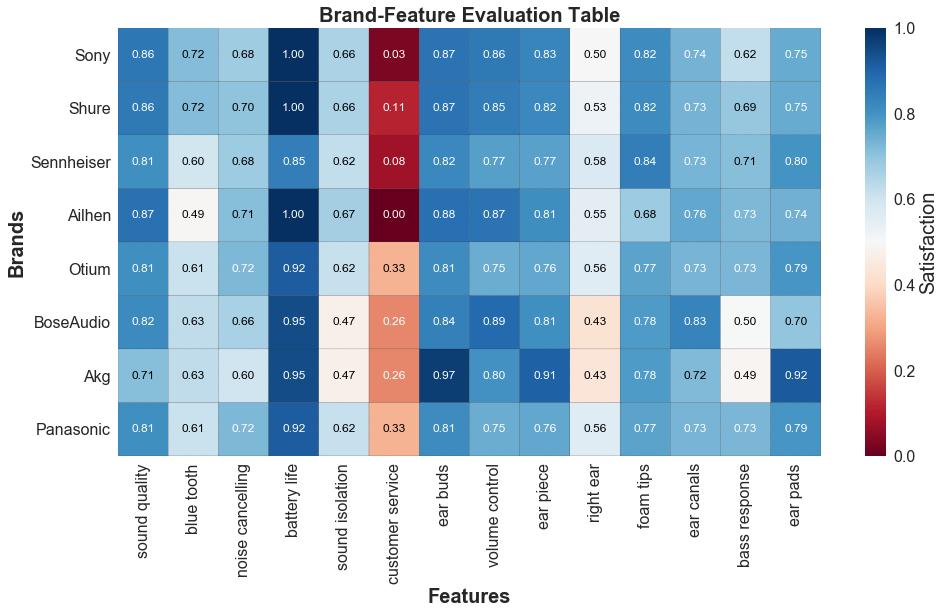

In [695]:
import numpy as np
import matplotlib.pyplot as plt


def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: http://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.get_axes()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: http://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels):
    '''
    Inspired by:
    - http://stackoverflow.com/a/16124677/395857 
    - http://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)


    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) +0.5 , minor=False)


    #ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)
    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)


    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    cbar = plt.colorbar(c)  
    cbar.update_ticks()    
    
    cbar.set_label("Satisfaction",size=20)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.yaxis.get_offset_text().set(size=20)

    # Add text in each cell 
    show_values(c)

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(40, 20))





x_axis_size = len(Final_table)
y_axis_size = len(Final_table[0])
title = "Review Table"

data = np.array(Final_table)
#data =  np.random.rand(y_axis_size,x_axis_size)
#xticklabels = range(1, x_axis_size+1) # could be text
#yticklabels = range(1, y_axis_size+1) # could be text 

xticklabels = selected_collocations_joint
yticklabels = BrandsList


xlabel, ylabel =" ", " "
heatmap(data, title, xlabel, ylabel, xticklabels, yticklabels)


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(rotation='vertical')
plt.title("Brand-Feature Evaluation Table",weight='bold', size=20)
plt.xlabel("Features",weight='bold', size=20)
plt.ylabel("Brands",weight='bold', size=20)
plt.savefig('image_output.png', dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures
plt.show()





In [699]:

Overall_dict = {}

Temp_list = []
Temp_dict = {}
df = pd.read_csv('All_Data.txt', encoding='utf-8')
print(len(df.index))
df = brand_df.rename(index=str, columns={"Unnamed: 0": "ID"})
df['Reviews'] = bdf['Reviews'].apply(lambda x : cleaned_reviews(str(x)))
reviews = brand_df['Reviews'].tolist()
reviews = [str(x) for x in brand_reviews]
raw_text = ' '.join(brand_reviews)
bigrams =get_bigram_likelihood(brand_raw_text, freq_filter=3, nbest=200 )

for bigram in selected_collocations_joint:
    Filtered_list = [select_sentence(review, bigram) for review in brand_reviews if filter_reviews(review, bigram)]

    if len(Filtered_list) > 0:
        df2 = pd.DataFrame({"Reviews":Filtered_list})
        df2['Sentiments'] = df2['Reviews'].apply(lambda x: review_sentiment(x))
        df2 = pd.concat([df2.drop(['Sentiments'], axis=1), df2['Sentiments'].apply(pd.Series)], axis=1)
        negativity = df2['neg'].sum()
        #print(negativity)
        positivity = df2['pos'].sum()
        Overall_dict.update({bigram:positivity/(positivity+negativity)})
    else:
        Overall_dict.update({bigram:-1})

#Final_result.update({Brand: sorted(Temp_list, key = lambda x:x[1])})   
print(Overall_dict)
features = sorted(Overall_dict.keys(), key = lambda x:Overall_dict[x])
satisfaction = sorted(Overall_dict.values(), key = lambda x:x)
print(features)

    




48039
{'sound quality': 0.8066209013304834, 'blue tooth': 0.7457627118644068, 'noise cancelling': 0.7282567171781485, 'battery life': 0.8662551440329218, 'sound isolation': 0.720813679245283, 'customer service': 0.45099484156226977, 'ear buds': 0.8104925134621356, 'volume control': 0.8052993459667953, 'ear piece': 0.7931335830212235, 'right ear': 0.6521568934471151, 'foam tips': 0.7877428998505231, 'ear canals': 0.7537847508945774, 'bass response': 0.7056633873969688, 'ear pads': 0.7598635103433568}
['customer service', 'right ear', 'bass response', 'sound isolation', 'noise cancelling', 'blue tooth', 'ear canals', 'ear pads', 'foam tips', 'ear piece', 'volume control', 'sound quality', 'ear buds', 'battery life']


In [706]:
satisfaction = sorted(Overall_dict.values(), key = lambda x:x)

In [739]:
def curvify(x, myList):
    minimum = min(myList)
    maximum = max(myList)
    y = (x-minimum)/(maximum-minimum)
    return 1-y**2

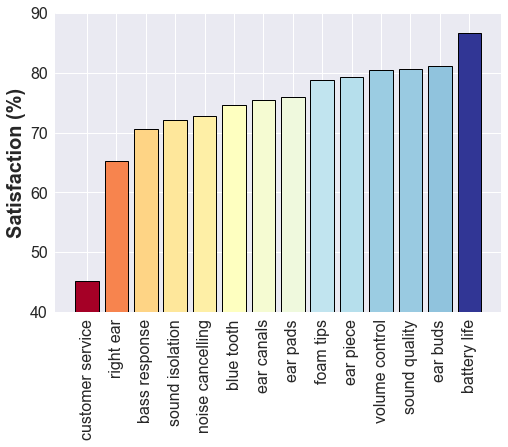

In [749]:
for i,s in zip(range(14), satisfaction):
    plt.bar(i, s*100, color=cm(curvify(s, satisfaction)), edgecolor='black',linewidth=1.0)
#plt.bar(range(14), satisfaction,align='center',cm(c))
x_pos = np.arange(len(satisfaction)) 
plt.xticks(x_pos, features, rotation='vertical') 
plt.ylim(40, 90) 

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylabel("Satisfaction (%)",weight='bold', size=20)
plt.savefig('features_hist.png', dpi=300, format='png', bbox_inches='tight')
plt.show()


In [758]:
Final_table = np.array([[Final_dict[Brand][collocation] for collocation in 
                         selected_collocations_joint] for Brand in BrandsList])

Final_table = [[Final_table[j][i] if Final_table[j][i]>-1 
                else np.mean([Final_table[k][i] for k in range(numOfBrands) if Final_table[k][i]>-1])
                             for i in range(numOfCollocations) ] 
               for j in range(numOfBrands)]


Final_brand_dict = {selected_collocations_joint[i]: {BrandsList[j]:Final_table[j][i]
                  for j in range(numOfBrands) }  for i in range(numOfCollocations)}

In [780]:
Final_brand_dict
Final_brand_sorted = { collocation: sorted(list(Final_brand_dict[collocation].keys()), 
                                           key = lambda x:Final_brand_dict[collocation][x]) 
                     for collocation in selected_collocations_joint} 

In [802]:
Final_brand_worst = { collocation: Final_brand_sorted[collocation][:2] 
                     for collocation in selected_collocations_joint}
Final_brand_best= { collocation: Final_brand_sorted[collocation][-2:] 
                     for collocation in selected_collocations_joint}

In [803]:
Final_brand_worst

{'bass response': ['Akg', 'BoseAudio'],
 'battery life': ['Sennheiser', 'Panasonic'],
 'blue tooth': ['Ailhen', 'Sennheiser'],
 'customer service': ['Ailhen', 'Sony'],
 'ear buds': ['Panasonic', 'Otium'],
 'ear canals': ['Akg', 'Sennheiser'],
 'ear pads': ['BoseAudio', 'Ailhen'],
 'ear piece': ['Panasonic', 'Otium'],
 'foam tips': ['Ailhen', 'Panasonic'],
 'noise cancelling': ['Akg', 'BoseAudio'],
 'right ear': ['BoseAudio', 'Akg'],
 'sound isolation': ['Akg', 'BoseAudio'],
 'sound quality': ['Akg', 'Panasonic'],
 'volume control': ['Panasonic', 'Otium']}

In [804]:
Final_brand_best

{'bass response': ['Panasonic', 'Otium'],
 'battery life': ['Shure', 'Sony'],
 'blue tooth': ['Shure', 'Sony'],
 'customer service': ['Panasonic', 'Otium'],
 'ear buds': ['Ailhen', 'Akg'],
 'ear canals': ['Ailhen', 'BoseAudio'],
 'ear pads': ['Sennheiser', 'Akg'],
 'ear piece': ['Sony', 'Akg'],
 'foam tips': ['Sony', 'Sennheiser'],
 'noise cancelling': ['Panasonic', 'Otium'],
 'right ear': ['Otium', 'Sennheiser'],
 'sound isolation': ['Sony', 'Ailhen'],
 'sound quality': ['Sony', 'Ailhen'],
 'volume control': ['Ailhen', 'BoseAudio']}

In [805]:
Final_brand_sorted

{'bass response': ['Akg',
  'BoseAudio',
  'Sony',
  'Shure',
  'Sennheiser',
  'Ailhen',
  'Panasonic',
  'Otium'],
 'battery life': ['Sennheiser',
  'Panasonic',
  'Otium',
  'Akg',
  'BoseAudio',
  'Ailhen',
  'Shure',
  'Sony'],
 'blue tooth': ['Ailhen',
  'Sennheiser',
  'Panasonic',
  'Otium',
  'Akg',
  'BoseAudio',
  'Shure',
  'Sony'],
 'customer service': ['Ailhen',
  'Sony',
  'Sennheiser',
  'Shure',
  'Akg',
  'BoseAudio',
  'Panasonic',
  'Otium'],
 'ear buds': ['Panasonic',
  'Otium',
  'Sennheiser',
  'BoseAudio',
  'Shure',
  'Sony',
  'Ailhen',
  'Akg'],
 'ear canals': ['Akg',
  'Sennheiser',
  'Panasonic',
  'Otium',
  'Shure',
  'Sony',
  'Ailhen',
  'BoseAudio'],
 'ear pads': ['BoseAudio',
  'Ailhen',
  'Shure',
  'Sony',
  'Panasonic',
  'Otium',
  'Sennheiser',
  'Akg'],
 'ear piece': ['Panasonic',
  'Otium',
  'Sennheiser',
  'BoseAudio',
  'Ailhen',
  'Shure',
  'Sony',
  'Akg'],
 'foam tips': ['Ailhen',
  'Panasonic',
  'Otium',
  'Akg',
  'BoseAudio',
  'Shur

In [806]:
Final_brand_table = []
for j in range(numOfBrands):
    Final_brand_table.append([])
    for i in range(numOfCollocations):
        Final_brand_table[j].append(0.5)
        if BrandsList[j] in Final_brand_best[selected_collocations_joint[i]]:
            Final_brand_table[j][i] = 1
        if BrandsList[j] in Final_brand_worst[selected_collocations_joint[i]]:
            Final_brand_table[j][i] = 0
        



In [807]:
Final_brand_table 

[[0, 0.5, 1, 0, 0.5, 1, 0, 0, 0, 0.5, 0, 0.5, 1, 0.5],
 [0, 0.5, 0, 0.5, 0, 0.5, 1, 0.5, 1, 0, 0.5, 0, 0, 1],
 [0.5, 0.5, 0, 0.5, 0, 0.5, 0.5, 1, 0.5, 0, 0.5, 1, 0, 0],
 [0.5, 0.5, 1, 0.5, 0.5, 1, 0, 0, 0, 1, 0.5, 0.5, 1, 0.5],
 [1, 0, 0.5, 0.5, 1, 0, 1, 1, 0.5, 0.5, 0, 1, 0.5, 0],
 [0.5, 0, 0.5, 0, 0.5, 0.5, 0.5, 0.5, 0.5, 1, 1, 0, 0.5, 1],
 [0.5, 1, 0.5, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 [1, 1, 0.5, 1, 1, 0, 0.5, 0.5, 1, 0.5, 1, 0.5, 0.5, 0.5]]

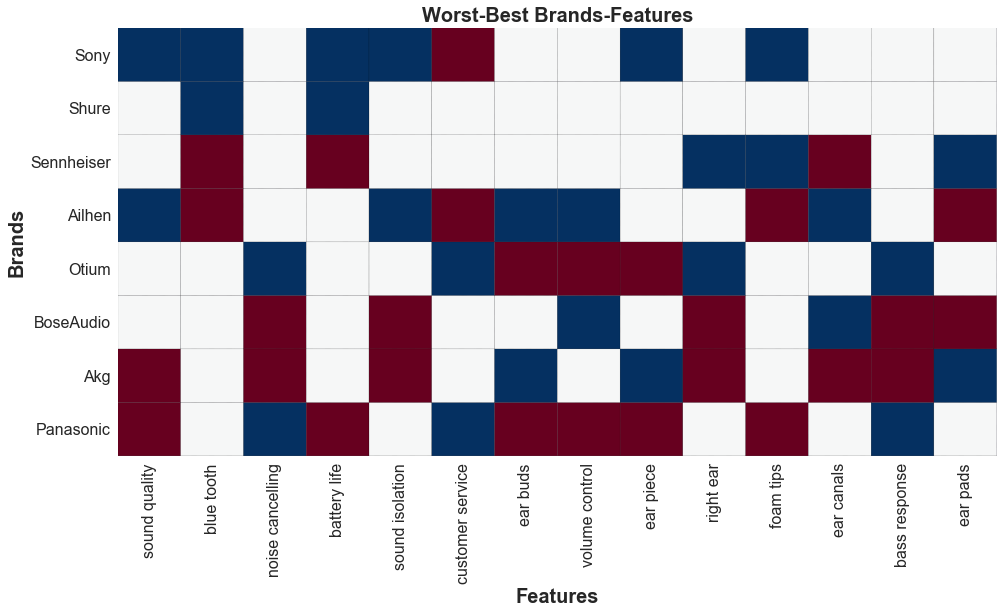

In [810]:
def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: http://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.get_axes()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)

def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: http://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels):
    '''
    Inspired by:
    - http://stackoverflow.com/a/16124677/395857 
    - http://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)


    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) +0.5 , minor=False)


    #ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)
    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)


    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    #cbar = plt.colorbar(c)  
    #cbar.update_ticks()    
    
    #cbar.set_label("Satisfaction",size=20)
    #cbar.ax.tick_params(labelsize=16)
    #cbar.ax.yaxis.get_offset_text().set(size=20)

    # Add text in each cell 
    #show_values(c)

    # resize 
    fig = plt.gcf()
    fig.set_size_inches(cm2inch(40, 20))





x_axis_size = len(Final_table)
y_axis_size = len(Final_table[0])
title = "Review Table"

data = np.array(Final_brand_table )
#data =  np.random.rand(y_axis_size,x_axis_size)
#xticklabels = range(1, x_axis_size+1) # could be text
#yticklabels = range(1, y_axis_size+1) # could be text 

xticklabels = selected_collocations_joint
yticklabels = BrandsList


xlabel, ylabel =" ", " "
heatmap(data, title, xlabel, ylabel, xticklabels, yticklabels)


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(rotation='vertical')
plt.title("Worst-Best Brands-Features",weight='bold', size=20)
plt.xlabel("Features",weight='bold', size=20)
plt.ylabel("Brands",weight='bold', size=20)
plt.savefig('image_output2.png', dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures
plt.show()



